In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cmdstanpy import CmdStanModel
from baynes.plotter import FitPlotter
from baynes.model_utils import get_stan_file
import pandas as pd
from scipy import stats
sns.set_style('ticks')

sns.set_context("notebook", font_scale=1.6)
plt.rc("axes.spines", top=False, right=False)
import cmdstanpy
import logging
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
import arviz as az
import matplotlib as mpl
from matplotlib import cycler
colors = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"][5:8]#['#1b9e77','#e7298a','#d95f02','#7570b3','#66a61e','#e6ab02','#a6761d','#666666']
mpl.rcParams['axes.prop_cycle'] = cycler('color',colors)
#plt.style.use('rose-pine-dawn')

# Example 1: fit of a poissonian process
### Generate the data

### Compile and print the STAN model


In [71]:
stan_file = get_stan_file('poisson_SBC.stan')
model = CmdStanModel(stan_file=stan_file,
                     cpp_options={'STAN_THREADS': True, 'jN': 4})
print(model.code())

Found .stan file  /home/pietro/work/TESI/baynes/stan/models/poisson/poisson_SBC.stan
data {
  int<lower=0> N;
  real alpha;
  real beta;
  real alpha_true;
  real beta_true;
}
transformed data {
  real<lower = 0> lambda_sim = gamma_rng(alpha_true, beta_true);
  array[N] int<lower = 0> y = poisson_rng(rep_array(lambda_sim, N));
}
parameters {
  real<lower=0> lambda;
}
model {
  lambda ~ gamma(alpha, beta);
  y ~ poisson(lambda);
}
generated quantities {
  int<lower = 0, upper = 1> lt_lambda  = lambda < lambda_sim;
}


In [72]:
from baynes.analysis import multithreaded_run

In [73]:
def SBC_plot(data, n_bins, percs=[0.05, 0.95]):
    if isinstance(data, str):
        data = pd.read_json(data)
    elif isinstance(data, dict):
        data = pd.DataFrame.from_dict(data)
    hist = sns.displot(data.melt(value_name='rank'), bins=n_bins, kind='hist', x='rank', col='variable', col_wrap=2, alpha=1)
    pdf = stats.binom(len(data), 1/n_bins)
    hist.set_titles("")
    for ax in hist.axes.flatten():
        xlim = ax.get_xlim()
        ax.fill_between(ax.get_xlim(), pdf.ppf(percs[0]), pdf.ppf(percs[1]), color='grey', alpha=0.20, zorder=0)
        ax.axhline(pdf.median(), color='grey', alpha=0.50, zorder=0)
        ax.set_xlim(xlim)
        ax.grid(visible=False)
    return hist

def ECDF_plot(data, n_bins, percs=[0.05, 0.95]):
    if isinstance(data, str):
        data = pd.read_json(data)
    elif isinstance(data, dict):
        data = pd.DataFrame.from_dict(data)
    hist = sns.displot(data.melt(value_name='rank'), bins=n_bins, kind='hist', x='rank', col='variable', hue='variable', col_wrap=2, alpha=1)
    pdf = stats.binom(len(data), 1/n_bins)
    
    for ax in hist.axes.flatten():
        xlim = ax.get_xlim()
        ax.fill_between(ax.get_xlim(), pdf.ppf(percs[0]), pdf.ppf(percs[1]), color='green', alpha=0.20, zorder=0)
        ax.axhline(pdf.median(), color='green', alpha=0.50, zorder=0)
        ax.set_xlim(xlim)
        ax.grid(visible=False)
    return hist

In [74]:
def run_SBC(model):
    data = {'N': 500, 'alpha':5, 'beta':1, 'alpha_true':5, 'beta_true':1}
    fit = model.sample(data,
                         chains=1,
                         iter_warmup=200,
                         iter_sampling=398,
                         save_warmup=False,
                         show_progress=False,
                         thin=2)
    df = fit.draws_pd('lt_lambda')
    rank = np.sum(df.to_numpy())
    return rank
rank = multithreaded_run(run_SBC, [model]*400, 4)


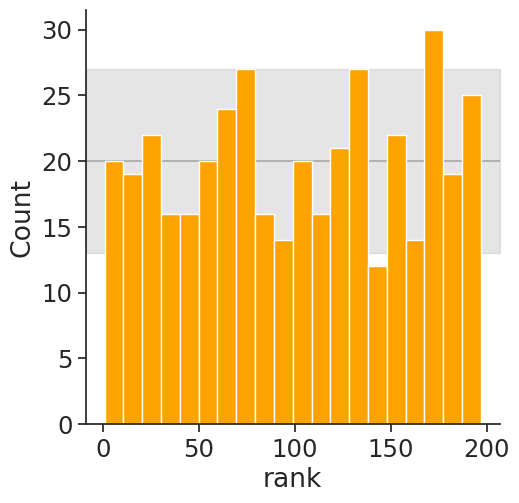

In [89]:
fplot = FitPlotter(output_dir="/home/pietro/work/TESI/thesis/figures/ch2/poisson/", output_format='.pdf')
hist = SBC_plot({'lambda':rank}, 20)
fplot.new_figure('SBChist', hist.figure)
fplot.resize(10,6)


In [88]:
pdf = stats.uniform(0,200)

ax = fplot.new_figure('SBCecdf').subplots()
ax = az.plot_ecdf(rank, cdf = pdf.cdf, difference=True, ax=ax,  plot_kwargs={'alpha':1, 'zorder':5}, fill_kwargs={'color': 'grey'})
ax.set_xlabel('rank')
ax.set_ylabel('ECDF difference')
ax.plot([0]*200, ls='--', color='black', alpha=0.4)
fplot.resize(8,6)
fplot.save_figures('all')

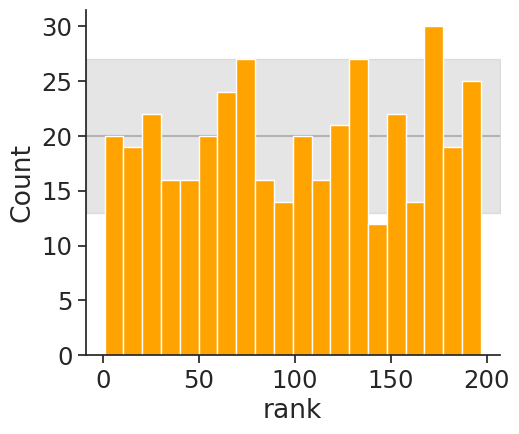

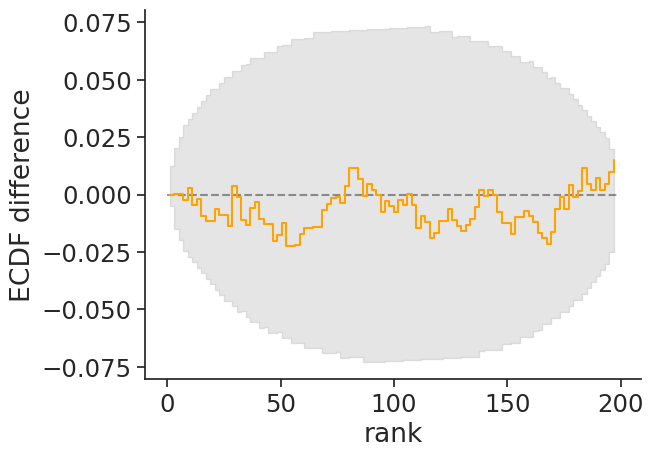

In [86]:

SBC_plot({'lambda':rank}, 20)
pdf = stats.uniform(0,200)
ax = az.plot_ecdf(rank, cdf = pdf.cdf, difference=True, plot_kwargs={'alpha':1, 'zorder':5}, fill_kwargs={'color': 'grey'})
ax.set_xlabel('rank')
ax.set_ylabel('ECDF difference')
ax.plot([0]*200, ls='--', color='black', alpha=0.4)


In [78]:
exp = len(rank)/20
counts, bins=np.histogram(rank, bins=20)
chi_test = sum([(a-exp)**2/exp for a in counts])

In [79]:
chi_test

22.5

In [80]:
stats.chi2.sf(chi_test, 20)

0.3140067262270574

In [81]:
chi_test

22.5

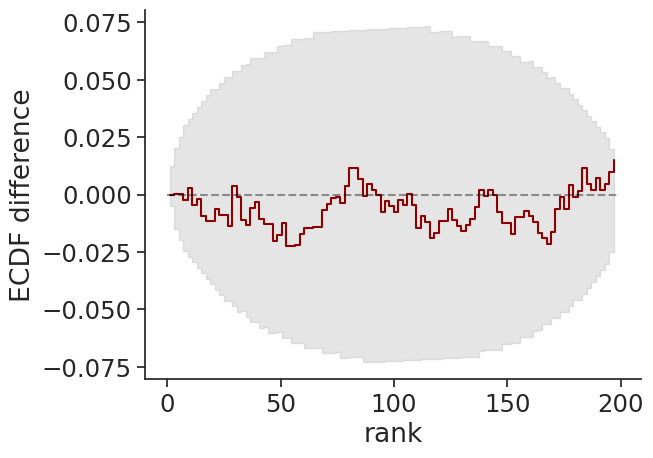

In [82]:
pdf = stats.uniform(0,200)
ax = az.plot_ecdf(rank, cdf = pdf.cdf, difference=True, plot_kwargs={'color': 'darkred'}, fill_kwargs={'color': 'grey'})
ax.set_xlabel('rank')
ax.set_ylabel('ECDF difference')
ax.plot([0]*200, ls='--', color='black', alpha=0.4)

(array([  1.,   0.,   3.,   8.,  16.,  30.,  34.,  64., 111., 144., 184.,
        220., 329., 419., 492., 503., 561., 614., 596., 618., 603., 572.,
        537., 510., 438., 428., 348., 296., 242., 220., 171., 130., 120.,
         92.,  81.,  76.,  43.,  36.,  32.,  21.,  20.,  16.,   7.,   3.,
          2.,   1.,   3.,   3.,   1.,   1.]),
 array([ 6.06837316,  6.74516354,  7.42195391,  8.09874429,  8.77553466,
         9.45232503, 10.12911541, 10.80590578, 11.48269616, 12.15948653,
        12.83627691, 13.51306728, 14.18985765, 14.86664803, 15.5434384 ,
        16.22022878, 16.89701915, 17.57380953, 18.2505999 , 18.92739027,
        19.60418065, 20.28097102, 20.9577614 , 21.63455177, 22.31134215,
        22.98813252, 23.66492289, 24.34171327, 25.01850364, 25.69529402,
        26.37208439, 27.04887477, 27.72566514, 28.40245551, 29.07924589,
        29.75603626, 30.43282664, 31.10961701, 31.78640739, 32.46319776,
        33.13998813, 33.81677851, 34.49356888, 35.17035926, 35.84714963,
 

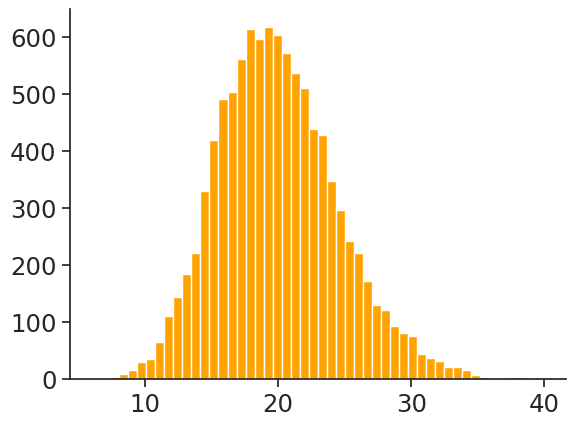

In [83]:
plt.hist(np.random.gamma(20,1, 10000), bins=50)